In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import matplotlib.colors as mcolors
import numpy as np
import cv2

In [2]:
image_rgb = cv2.imread('dali.jpeg')
image_rgb = cv2.cvtColor(src=image_rgb, code=cv2.COLOR_BGR2RGB)
B = cv2.cvtColor(src=image_rgb, code=cv2.COLOR_RGB2GRAY)

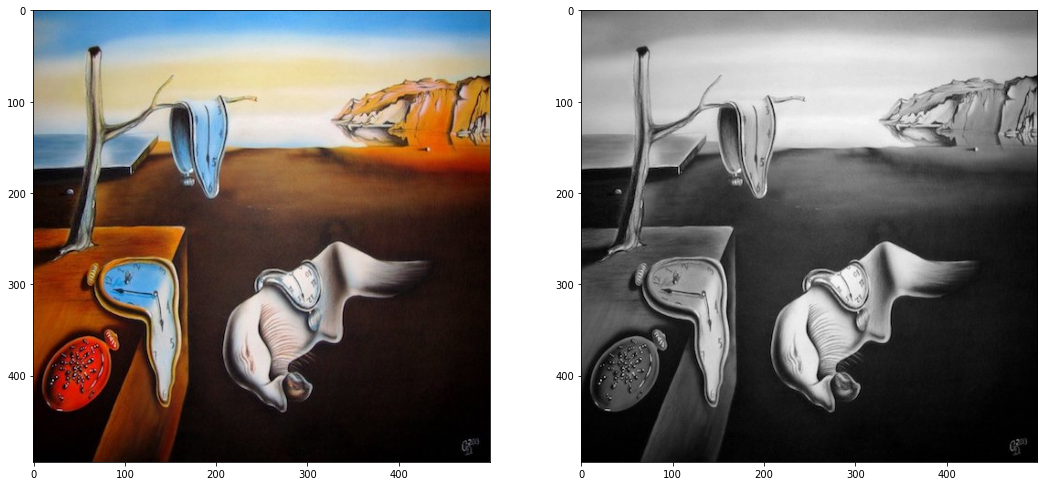

In [3]:
fig, (N, bri) = plt.subplots(1, 2, figsize=(18, 10))
N.imshow(image_rgb.astype(int))
bri.imshow(B, cmap=plt.get_cmap('gray'))
plt.show()

In [4]:
V_kernel = [
    [-0.25, 0, 0.25],
    [-0.5, 0, 0.5],
    [-0.25, 0, 0.25]
]

H_kernel = [
    [-0.25, -0.5, -0.25],
    [0, 0, 0],
    [0.25, 0.5, 0.25]
]

V_kernel = np.array(V_kernel)
H_kernel = np.array(H_kernel)
Kernel = V_kernel + H_kernel
print(Kernel)

[[-0.5 -0.5  0. ]
 [-0.5  0.   0.5]
 [ 0.   0.5  0.5]]


In [5]:
def convolute(B, K):
    kernel = np.flipud(np.fliplr(K))
    xB = B.shape[0]
    yB = B.shape[1]
    brightness = np.pad(B, (1, 1), 'constant', constant_values=0)
    output = np.zeros((xB, yB))

    for y in range(1, xB + 1):
        for x in range(1, yB + 1):
            output[y-1][x-1] = abs((K * brightness[y-1:y+2, x-1:x+2]).sum())
    
    output -= output.min()
    output /= output.max()
    return output

In [6]:
def compute_edges(B, K):
    horizontal = convolute(B, H_kernel)
    vertical = convolute(B, V_kernel)
    output = horizontal + vertical
    return output / output.max()

0.0 1.0


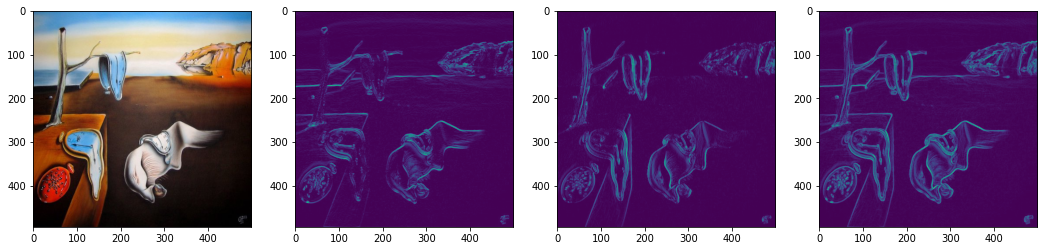

In [7]:
horizontal = convolute(B, H_kernel)
vertical = convolute(B, V_kernel)
edges = compute_edges(B, Kernel)

print(edges.min(), edges.max())

fig, (N, hor, ver, E) = plt.subplots(1, 4, figsize=(18, 10))
N.imshow(image_rgb.astype(int))
hor.imshow(horizontal, vmin=0, vmax=1)
ver.imshow(vertical, vmin=0, vmax=1)
E.imshow(edges, vmin=0, vmax=1)
plt.show()

In [8]:
def compute_weights(edges):
    weights = edges.copy()
    directions = np.zeros(shape=(len(edges), len(edges[0])))
    for y in range(len(weights)-2, -1, -1):
        for x in range(len(weights[0])):
            best = 0
            for i in range(-1, 2):
                if x + i > -1 and x + i < len(weights[0]):
                    if weights[y+1][x+i] < weights[y+1][x+best]:
                        best = i
            directions[y][x] = best
            weights[y][x] = weights[y][x] + weights[y+1][x+best]
    weights = weights / weights.max()
    return weights, directions

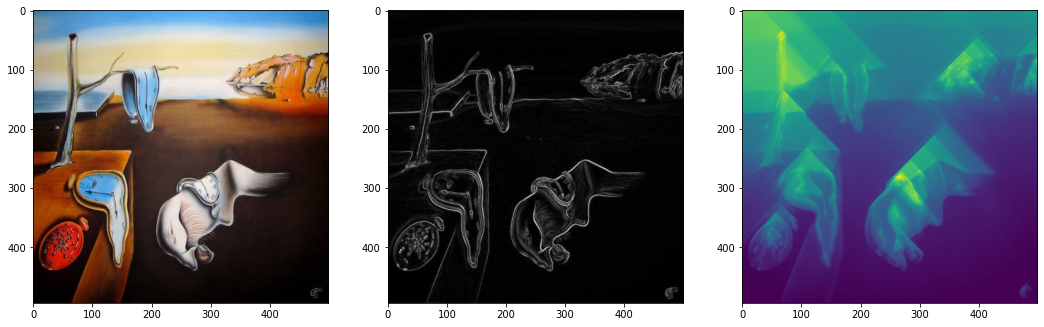

In [9]:
weights, directions = compute_weights(edges)


fig, (N, E, W) = plt.subplots(1, 3, figsize=(18, 10))
N.imshow(image_rgb.astype(int))
E.imshow(edges, vmin=0, vmax=1, cmap='gray')
W.imshow(weights, vmin=0, vmax=1)

In [10]:
def shorten(image, weights, directions):
    raw = image.copy()
    cropped = []
    start = 0
    for i in range(len(weights[0])):
        if weights[0][i] < weights[0][start]:
            start = i

    seam = [int(start)]
    for y in range(len(weights)):
        seam.append(int(seam[-1]+directions[y][seam[-1]]))
        raw[y][seam[-1]] = [255, 0, 0]
        row = np.delete(image[y], seam[-1], axis=0)
        cropped.append(row)

    return raw, np.array(cropped)
        

In [11]:
cropped = image_rgb.copy()

0 

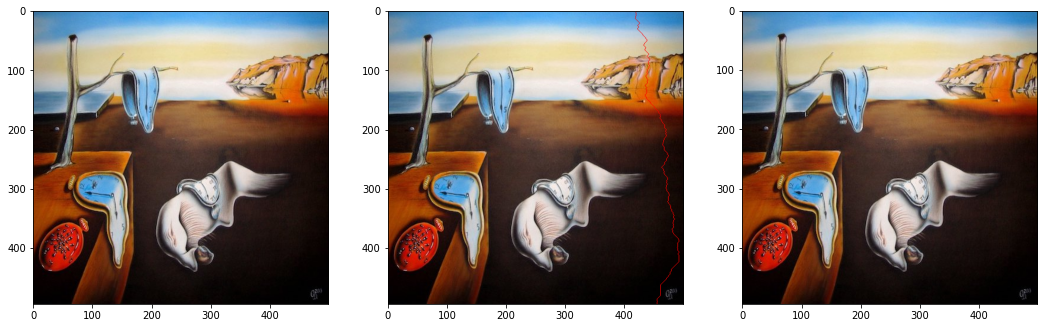

In [12]:
# raw, cropped = shorten(image_rgb, weights, directions)

for i in range(1): #int(image_rgb.shape[0] * 0.25)):
    b = cv2.cvtColor(src=cropped, code=cv2.COLOR_RGB2GRAY)
    e = compute_edges(b, Kernel)
    w, d = compute_weights(e)
    raw, cropped = shorten(cropped, w, d)
    print(i, end=' ')

fig, (N, R, C) = plt.subplots(1, 3, figsize=(18, 10))
N.imshow(image_rgb.astype(int))
R.imshow(raw.astype(int))
C.imshow(cropped.astype(int))
plt.show()